# 잔차분산에 따른 모형의 예측력 비교

generated data : ###########################################fin


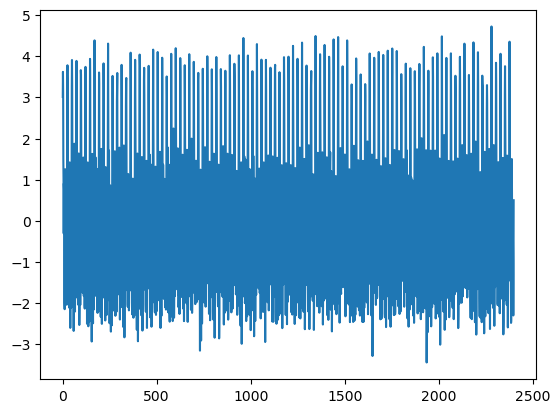

In [1]:
from simul240709_1_3 import *

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam
import time
#from pretraindata_simulation72_24_scale import sclae_X_train,sclae_y_train

from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Lambda
from tensorflow.keras.callbacks import EarlyStopping

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:

# nbeats 파라미터
horizon = 24
lookback = 3
input_dim, output_dim =  1, 1
backcast= horizon*lookback
forecast = horizon #7
#Num= 100
#epoch = 20
batch_size = 4
model_data = [split_train_test([random_simul_yt[i].round(3)],horizon,lookback ) for i in range(len(random_simul_yt))]



In [4]:

##################################################################################################
## sample size = 1000, no trend
#######################################################################################################################################

#X_train,y_train,X_test,y_test = [split_train_test([random_simul_yt[i].round(3)],horizon,lookback ) for i in range(len(random_simul_nt))][0]

nbeats_nt1000_score = []
nbeats_nt1000_lst = []
nbeats_nt1000_time = []


Num=100
epoch = 300
batch_size = 4

for next_ in range(Num):
    X_train,y_train,X_test,y_test = inputs_total[next_].values,outputs_total[next_],x_test_total[next_],y_test_[next_]

    K.clear_session()
    model1= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=1, thetas_dim=(1,3),
                       share_weights_in_stack=True, hidden_layer_units=64)
    optimizer = Adam(learning_rate=0.00001)
    model1.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model1.fit(X_train,y_train, validation_split = 0.15,
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model1.predict(X_test.reshape(1,-1))
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_nt1000_lst.append(pred.flatten())
    nbeats_nt1000_score.append([me1,me2,me3])
    nbeats_nt1000_time.append(nbeat_time2-nbeat_time1)
    del model1
print("nbeats_종료###############################################################")    
#######################################################################################################################################



1/1 [==============================] - 0s 135ms/step
nbeats_종료###############################################################


In [5]:


def build_model(input_timesteps=backcast, output_timesteps=horizon, features=1):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(input_timesteps, features)))
    # Use Lambda layer to select the last 'output_timesteps' outputs
    model.add(Lambda(lambda x: x[:, -output_timesteps:, :]))
    model.add(TimeDistributed(Dense(1)))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer)
    return model
lstm_nt1000_score = []
lstm_nt1000_lst = []
lstm_nt1000_time = []

for i in range(Num):
    X_train,y_train,X_test,y_test = inputs_total[next_].values,outputs_total[next_],x_test_total[next_],y_test_[next_]

    K.clear_session()
    lstm_model1 = build_model()
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0,restore_best_weights=True)
    time1 = time.time()
    history = lstm_model1.fit(X_train, y_train,validation_split = 0.15, 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model1.predict(X_test.reshape(1,-1))
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_nt1000_lst.append(pred.flatten())
    lstm_nt1000_score.append([me1,me2,me3])
    lstm_nt1000_time.append(time2-time1)
    del lstm_model1
print("lstm_종료###############################################################")    


1/1 [==============================] - 0s 274ms/step
lstm_종료###############################################################


In [16]:
pd.DataFrame(np.array(lstm_nt1000_score)).to_csv("lstm_2000_240710.csv")

array([[<Axes: title={'center': '0'}>]], dtype=object)

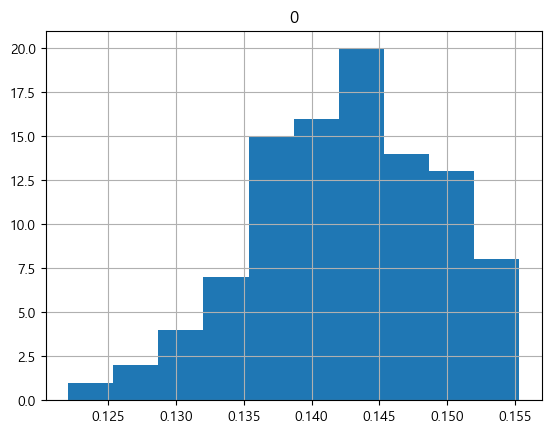

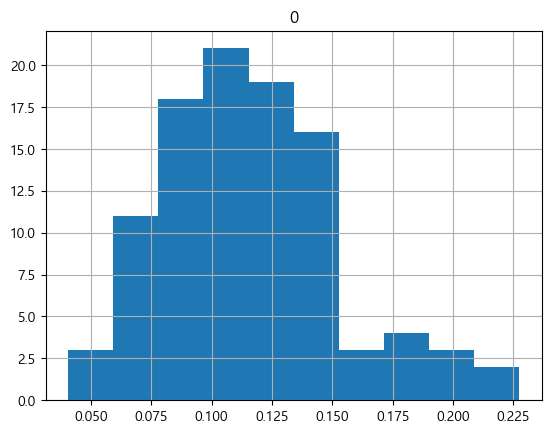

In [7]:
pd.DataFrame(np.array(lstm_nt1000_score)[:,0]).hist()
pd.DataFrame(np.array(nbeats_nt1000_score)[:,0]).hist()

In [ ]:
pd.DataFrame(np.array(lstm_nt1000_score)[:,0]).hist()

In [8]:
pd.DataFrame({'lstm_time':np.array(lstm_nt1000_time),
              'nbeats_time':np.array(nbeats_nt1000_time)}).to_csv('lstm_nbeats_2000_1_3time.csv')

In [6]:
np.array(lstm_nt1000_score).mean(axis=0) ,np.array(nbeats_nt1000_score).mean(axis=0)

(array([0.14252091, 0.33005767, 0.44800806]),
 array([0.11655578, 0.27095248, 0.74987334]))

In [11]:
pd.DataFrame(np.array(lstm_nt1000_score)).to_csv('lstm_2000_1_3score.csv')
pd.DataFrame(np.array(nbeats_nt1000_score)).to_csv('nbeats_2000_1_3score.csv')

In [42]:
X_train[-997:,:].shape, y_train.values[-997:,:].shape

((997, 72), (997, 24))

In [13]:

##################################################################################################
## sample size = 1000, no trend
#######################################################################################################################################

#X_train,y_train,X_test,y_test = [split_train_test([random_simul_yt[i].round(3)],horizon,lookback ) for i in range(len(random_simul_nt))][0]

nbeats_nt1000_score2 = []
nbeats_nt1000_lst2 = []
nbeats_nt1000_time2 = []


Num=100
epoch = 300
batch_size = 4

for next_ in range(Num):
    X_train,y_train,X_test,y_test = inputs_total[next_].values,outputs_total[next_],x_test_total[next_],y_test_[next_]

    K.clear_session()
    model1= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=1, thetas_dim=(1,3),
                       share_weights_in_stack=True, hidden_layer_units=64)
    optimizer = Adam(learning_rate=0.00001)
    model1.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model1.fit(X_train[-997:,:],y_train.values[-997:,:], validation_split = 0.15,
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model1.predict(X_test.reshape(1,-1))
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_nt1000_lst2.append(pred.flatten())
    nbeats_nt1000_score2.append([me1,me2,me3])
    nbeats_nt1000_time2.append(nbeat_time2-nbeat_time1)
    del model1
print("nbeats_종료###############################################################")  





def build_model(input_timesteps=backcast, output_timesteps=horizon, features=1):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(input_timesteps, features)))
    # Use Lambda layer to select the last 'output_timesteps' outputs
    model.add(Lambda(lambda x: x[:, -output_timesteps:, :]))
    model.add(TimeDistributed(Dense(1)))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer)
    return model
lstm_nt1000_score2 = []
lstm_nt1000_lst2 = []
lstm_nt1000_time2 = []

for i in range(Num):
    X_train,y_train,X_test,y_test = inputs_total[next_].values,outputs_total[next_],x_test_total[next_],y_test_[next_]

    K.clear_session()
    lstm_model1 = build_model()
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0,restore_best_weights=True)
    time1 = time.time()
    history = lstm_model1.fit(X_train[-997:,:], y_train.values[-997:,:],validation_split = 0.15, 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model1.predict(X_test.reshape(1,-1))
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_nt1000_lst2.append(pred.flatten())
    lstm_nt1000_score2.append([me1,me2,me3])
    lstm_nt1000_time2.append(time2-time1)
    del lstm_model1
print("lstm_종료###############################################################")    


1/1 [==============================] - 0s 139ms/step
nbeats_종료###############################################################
1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 277ms/step
lstm_종료###############################################################


In [12]:
np.array(lstm_nt1000_score2).mean(axis=0) ,np.array(nbeats_nt1000_score2).mean(axis=0)

NameError: name 'lstm_nt1000_score2' is not defined

In [14]:

##################################################################################################
## sample size = 1000, no trend
#######################################################################################################################################

#X_train,y_train,X_test,y_test = [split_train_test([random_simul_yt[i].round(3)],horizon,lookback ) for i in range(len(random_simul_nt))][0]

nbeats_nt1000_score3 = []
nbeats_nt1000_lst3 = []
nbeats_nt1000_time3 = []


Num=100
epoch = 300
batch_size = 4

for next_ in range(Num):
    X_train,y_train,X_test,y_test = inputs_total[next_].values,outputs_total[next_],x_test_total[next_],y_test_[next_]

    K.clear_session()
    model1= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=1, thetas_dim=(1,3),
                       share_weights_in_stack=True, hidden_layer_units=64)
    optimizer = Adam(learning_rate=0.00001)
    model1.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model1.fit(X_train[-1497:,:],y_train.values[-1497:,:], validation_split = 0.15,
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model1.predict(X_test.reshape(1,-1))
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_nt1000_lst3.append(pred.flatten())
    nbeats_nt1000_score3.append([me1,me2,me3])
    nbeats_nt1000_time3.append(nbeat_time2-nbeat_time1)
    del model1
print("nbeats_종료###############################################################")  





def build_model(input_timesteps=backcast, output_timesteps=horizon, features=1):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(input_timesteps, features)))
    # Use Lambda layer to select the last 'output_timesteps' outputs
    model.add(Lambda(lambda x: x[:, -output_timesteps:, :]))
    model.add(TimeDistributed(Dense(1)))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer)
    return model
lstm_nt1000_score3 = []
lstm_nt1000_lst3 = []
lstm_nt1000_time3 = []

for i in range(Num):
    X_train,y_train,X_test,y_test = inputs_total[next_].values,outputs_total[next_],x_test_total[next_],y_test_[next_]

    K.clear_session()
    lstm_model1 = build_model()
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0,restore_best_weights=True)
    time1 = time.time()
    history = lstm_model1.fit(X_train[-1497:,:], y_train.values[-1497:,:],validation_split = 0.15, 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model1.predict(X_test.reshape(1,-1))
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_nt1000_lst3.append(pred.flatten())
    lstm_nt1000_score3.append([me1,me2,me3])
    lstm_nt1000_time3.append(time2-time1)
    del lstm_model1
print("lstm_종료###############################################################")    

1/1 [==============================] - 0s 140ms/step
nbeats_종료###############################################################
1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 278ms/step
lstm_종료###############################################################


In [15]:
sigma1= pd.DataFrame({'lstm2000' :np.array(lstm_nt1000_score).mean(axis=0) ,
              'nbeats2000' :np.array(nbeats_nt1000_score).mean(axis=0),
             'lstm1000' :np.array(lstm_nt1000_score2).mean(axis=0) ,
              'nbeats1000' :np.array(nbeats_nt1000_score2).mean(axis=0),
             'lstm500' :np.array(lstm_nt1000_score3).mean(axis=0) ,
              'nbeats500' :np.array(nbeats_nt1000_score3).mean(axis=0)}).T
sigma1.columns = ['mse' ,'mae','mape']
sigma1.to_csv('metric_sigma1_3.csv')

In [16]:
sigma1

,mse,mae,mape
lstm2000,0.142521,0.330058,0.448008
nbeats2000,0.116556,0.270952,0.749873
lstm1000,0.145267,0.331498,0.447424
nbeats1000,0.121749,0.278888,0.767022
lstm500,0.143253,0.331267,0.449386
nbeats500,0.122426,0.278119,0.752661


In [25]:
time1= pd.DataFrame({'lstm2000' :np.array(lstm_nt1000_time),
              'nbeats2000' :np.array(nbeats_nt1000_time),
             'lstm1000' :np.array(lstm_nt1000_time2),
              'nbeats1000' :np.array(nbeats_nt1000_time2),
             'lstm500' :np.array(lstm_nt1000_time3),
              'nbeats500' :np.array(nbeats_nt1000_time3)}).T

In [27]:
time1.to_csv('time_1_3.csv')

---

In [18]:
pd.DataFrame(lstm_nt1000_score3).to_csv('lstm500_1_3.csv')
pd.DataFrame(nbeats_nt1000_score3).to_csv('nbeats500_1_3.csv')
pd.DataFrame(lstm_nt1000_score2).to_csv('lstm1000_1_3.csv')
pd.DataFrame(nbeats_nt1000_score2).to_csv('nbeats1000_1_3.csv')
pd.DataFrame(lstm_nt1000_score).to_csv('lstm2000_1_3.csv')
pd.DataFrame(nbeats_nt1000_score).to_csv('nbeats2000_1_3.csv')

(array([ 1.,  2.,  4.,  7., 15., 16., 20., 14., 13.,  8.]),
 array([0.12201978, 0.12535019, 0.12868059, 0.132011  , 0.1353414 ,
        0.13867181, 0.14200221, 0.14533261, 0.14866302, 0.15199342,
        0.15532383]),
 <BarContainer object of 10 artists>)

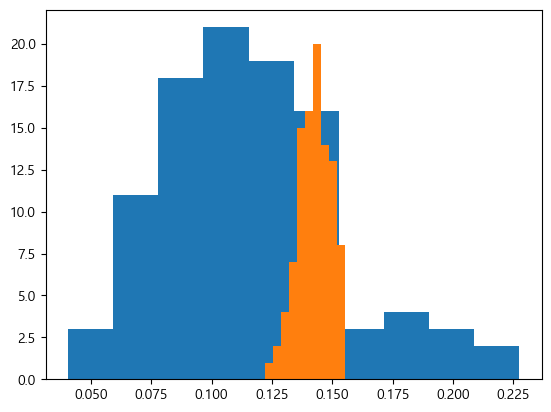

In [23]:
plt.hist(np.array(nbeats_nt1000_score)[:,0])
plt.hist(np.array(lstm_nt1000_score)[:,0])

(array([58., 40.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.21282741, 1.299962  , 1.38709659, 1.47423118, 1.56136577,
        1.64850036, 1.73563495, 1.82276954, 1.90990413, 1.99703872,
        2.08417331]),
 <BarContainer object of 10 artists>)

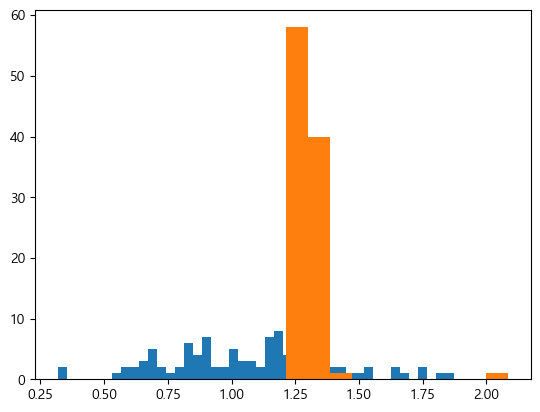

In [80]:
plt.hist(np.array(nbeats_nt1000_score3)[:,0],bins=50)
plt.hist(np.array(lstm_nt1000_score3)[:,0])